In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting

In [4]:
from multiprocessing import Pool
import pickle
from collections import defaultdict

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA

In [6]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [7]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [8]:
results_prefix = "[WIKIDATA_NOBOT]"

sequence_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_sequences.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels.p")
users_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_users.p")

In [9]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,is_bot,length,sequence,user_id,user_name
0,False,1511,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...",1,Hoo man
1,False,9,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...",1000036,JShenk
2,False,7,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",1000078,Egor-belikov
3,False,9,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...",100008,Wars
4,False,44,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",100012,Kane 14


In [10]:
break_label = cfg.get("preprocessing", "break_label")
break_label

'BREAK'

In [11]:
df["length_nobreak"] = df['sequence'].progress_apply(lambda x: len([y for y in x if y != break_label]))

In [12]:
df.head()

,is_bot,length,sequence,user_id,user_name,length_nobreak
0,False,1511,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...",1,Hoo man,1379
1,False,9,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...",1000036,JShenk,6
2,False,7,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",1000078,Egor-belikov,4
3,False,9,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...",100008,Wars,6
4,False,44,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",100012,Kane 14,23


In [13]:
min_changes = 10

print(len(df), df['length'].sum())
df = df.loc[df['length_nobreak'] >= min_changes].reset_index(drop=True)
print(len(df), df['length'].sum())

87480 145207564
38036 144946013


In [14]:
print(len(df), df['length'].sum())
df = df.loc[~df['is_bot']].reset_index(drop=True)
print(len(df), df['length'].sum())

38036 144946013
37912 70497658


In [15]:
length_full = df.sort_values("length", ascending=False)['length'].values
length_nobreak = df.sort_values("length_nobreak", ascending=False)['length_nobreak'].values

In [16]:
from matplotlib import pyplot as plt

Text(0, 0.5, '$log$ Number of Edit Actions')

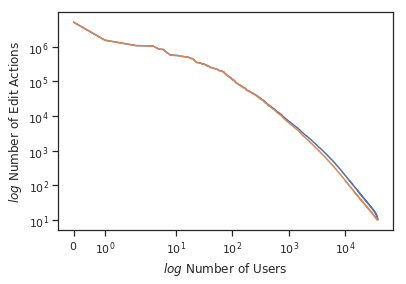

In [17]:
fig, ax = plt.subplots()
ax.plot(length_full)
ax.plot(length_nobreak)
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlabel("$log$ Number of Users")
ax.set_ylabel("$log$ Number of Edit Actions")

In [12]:
df['endbot'] = df['user_name'].progress_apply(lambda x: x.endswith("bot"))

In [13]:
df.loc[df['endbot']]

,is_bot,length,sequence,user_id,user_name,endbot
5573,False,12,"[SITELINK_UPDATE, SITELINK_UPDATE, SITELINK_UP...",1391699,Kanjybot,True
6210,False,7,"[SITELINK_UPDATE, BREAK, SITELINK_UPDATE, BREA...",14306,Trgbot,True
7042,False,46061,"[SITELINK_ADD, SITELINK_ADD, LABEL_ADD, DESCRI...",147889,Paucabot,True
11452,True,23039,"[SITELINK_UPDATE, SITELINK_UPDATE, SITELINK_UP...",176863,Lsjbot,True
13846,False,355,"[SITELINK_REMOVE, BREAK, SITELINK_REMOVE, SITE...",190961,Maskbot,True
14137,False,2,"[LABEL_ADD, ALIAS_ADD]",192997,MichalHobot,True
14456,False,33345,"[SITELINK_UPDATE, SITELINK_UPDATE, SITELINK_UP...",1953626,Cydebot,True
17283,False,21,"[SITELINK_UPDATE, BREAK, SITELINK_UPDATE, BREA...",2166790,BadRobot,True
19152,False,79,"[SITELINK_UPDATE, SITELINK_UPDATE, SITELINK_UP...",228706,Gubot,True
23214,False,3,"[DESCRIPTION_ADD, DESCRIPTION_UPDATE, DESCRIPT...",2619087,Roccobot,True
